In [1]:
import ROOT

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x3404b10
Welcome to JupyROOT 6.26/10


In [2]:
ROOT.EnableImplicitMT(4)

In [3]:
#%jsroot on

In [4]:
ROOT.gSystem.Load("libedm4hep")
ROOT.gSystem.Load("libpodio")
ROOT.gSystem.Load("libFCCAnalyses")

0

In [5]:
_edm  = ROOT.edm4hep.ReconstructedParticleData()
_pod  = ROOT.podio.ObjectID()
_fcc  = ROOT.dummyLoader

In [6]:
#df = ROOT.RDataFrame("events", "test_4f_sw_sl_eL_pR_edm4hep.root")
df = ROOT.RDataFrame("events", "E250-SetA.P4f_sw_sl.Gwhizard-2_8_5.eL.pR.I500106.0_edm4hep.root")

In [7]:
df.Describe()

Dataframe from TChain events in file E250-SetA.P4f_sw_sl.Gwhizard-2_8_5.eL.pR.I500106.0_edm4hep.root

Property                Value
--------                -----
Columns in total           39
Columns from defines        0
Event loops run             0
Processing slots            4

Column                                  Type                                            Origin
------                                  ----                                            ------
EventHeader                             ROOT::VecOps::RVec<edm4hep::EventHeaderData>    Dataset
EventHeader.eventNumber                 ROOT::VecOps::RVec<Int_t>                       Dataset
EventHeader.runNumber                   ROOT::VecOps::RVec<Int_t>                       Dataset
EventHeader.timeStamp                   ROOT::VecOps::RVec<ULong_t>                     Dataset
EventHeader.weight                      ROOT::VecOps::RVec<Float_t>                     Dataset
MCParticles                             ROOT::V

In [8]:
%%cpp
ROOT::VecOps::RVec<edm4hep::MCParticleData> get_enu(ROOT::VecOps::RVec<edm4hep::MCParticleData> in) {
    ROOT::VecOps::RVec<edm4hep::MCParticleData> res;
    for (size_t i = 0; i <= in.size(); i++) {
        const auto& mc = in[i];
        const auto& mc_next = in[i+1];
        if (abs(mc.PDG) == 11 && abs(mc_next.PDG) == 12) {
            res.push_back(mc);
            res.push_back(mc_next);
            break;
        }
    }
    return res;
}


In [9]:
%%cpp
ROOT::VecOps::RVec<edm4hep::MCParticleData> get_qq(ROOT::VecOps::RVec<edm4hep::MCParticleData> in) {
    ROOT::VecOps::RVec<edm4hep::MCParticleData> res;
    for (size_t i = 0; i <= in.size(); i++) {
        const auto& mc = in[i];
        const auto& mc_next = in[i+1];
        if (abs(mc.PDG) <= 5 && abs(mc_next.PDG) <= 5) {
            res.push_back(mc);
            res.push_back(mc_next);
            break;
        }
    }
    return res;
}

In [10]:
df2 = (df
       .Define("Electrons", "MCParticles[MCParticles.generatorStatus == 1 && abs(MCParticles.PDG) == 11]")
       .Define("Electrons_p", "FCCAnalyses::MCParticle::get_p(Electrons)")
       .Define("Electrons_theta", "FCCAnalyses::MCParticle::get_theta(Electrons)")
       .Define("Electrons_n", "Electrons.size()")
       .Define("LeadingElectron_index", "ArgMax(Electrons_p)")
       .Define("LeadingElectron_p", "Electrons_p[LeadingElectron_index]")
       .Define("LeadingElectron_theta", "Electrons_theta[LeadingElectron_index]")
       .Define("enu", "get_enu(MCParticles)")
       .Define("enu_p", "FCCAnalyses::MCParticle::get_p(enu)")
       .Define("enu_theta", "FCCAnalyses::MCParticle::get_theta(enu)")
       .Define("e", "enu[0]")
       .Define("nu", "enu[1]")
       .Define("e_p", "enu_p[0]")
       .Define("nu_p", "enu_p[1]")
       .Define("e_theta", "enu_theta[0]")
       .Define("nu_theta", "enu_theta[1]")
       .Define("enu_tlv", "FCCAnalyses::MCParticle::get_tlv(enu)")
       .Define("enu_W_tlv", "enu_tlv[0] + enu_tlv[1]")
       .Define("enu_invM", "(enu_tlv[0] + enu_tlv[1]).M()")
       .Define("qq", "get_qq(MCParticles)")
       .Define("qq_tlv", "FCCAnalyses::MCParticle::get_tlv(qq)")
       .Define("qq_W_tlv", "qq_tlv[0] + qq_tlv[1]")
       .Define("qq_invM", "qq_W_tlv.M()")
       .Define("qq_W_lv", "ROOT::Math::PxPyPzEVector(qq_W_tlv.Px(), qq_W_tlv.Py(), qq_W_tlv.Pz(), qq_W_tlv.E())")
       .Define("qq_W_cms_lv", "ROOT::Math::Boost(qq_W_lv.BoostToCM())(qq_W_lv)")
       .Define("qq_W_p", "qq_W_lv.P()")
       .Define("qq_W_theta", "qq_W_lv.Theta()")
       .Define("qq_W_cos_theta", "cos(qq_W_theta)")
       .Define("qq_W_cms_p", "qq_W_cms_lv.P()")
       .Define("e_tlv", "enu_tlv[0]")
       .Define("e_lv", "ROOT::Math::PxPyPzEVector(e_tlv.Px(), e_tlv.Py(), e_tlv.Pz(), e_tlv.E())")
       .Define("enu_lv", "ROOT::Math::PxPyPzEVector(enu_W_tlv.Px(), enu_W_tlv.Py(), enu_W_tlv.Pz(), enu_W_tlv.E())")
       .Define("beam_e_lv", "ROOT::Math::PxPyPzMVector(0.0, 0.0, 125.0, 0.00051)")
       .Define("beam_e_W_cms_lv", "ROOT::Math::Boost(beam_e_lv.BoostToCM(qq_W_lv))(beam_e_lv)")
       .Define("theta_W", "ROOT::Math::VectorUtil::Angle(qq_W_lv.Vect(), beam_e_lv.Vect())")
       .Define("cos_theta_W", "cos(theta_W)")
       .Define("e_seen", "abs(cos(e_theta)) < 0.989") # no silicon hits in ild below 8.5 deg
       .Define("enu_cms_lv", "ROOT::Math::Boost(enu_lv.BoostToCM())(enu_lv)")
       .Define("e_enu_cms_lv", "ROOT::Math::Boost(e_lv.BoostToCM(enu_lv))(e_lv)")
       .Define("e_decay_ang", "ROOT::Math::VectorUtil::Angle(enu_cms_lv.Vect(), e_enu_cms_lv.Vect())")
       )

In [11]:
h = {}
h["e_p"] = df2.Histo1D("e_p")
h["nu_p"] = df2.Histo1D("nu_p")
h["e_theta"] = df2.Histo1D("e_theta")
h["nu_theta"] = df2.Histo1D("nu_theta")
h["enu_invM"] = df2.Histo1D("enu_invM")
h["qq_invM"] = df2.Histo1D("qq_invM")
h["qq_W_p"] = df2.Histo1D("qq_W_p")
#h["qq_W_theta"] = df2.Histo1D("qq_W_theta")
#h["qq_W_cos_theta"] = df2.Histo1D("qq_W_cos_theta")
#h["qq_W_cms_p"] = df2.Histo1D("qq_W_cms_p")
#h["theta_W"] = df2.Histo1D("theta_W")
h["cos_theta_W-"] = df2.Filter("e.charge == +1").Histo1D(("", ";cos #theta_{W-}", 50, -1, 1), "cos_theta_W")
h["cos_theta_W+"] = df2.Filter("e.charge == -1").Histo1D(("", ";cos #theta_{W+}", 50, -1, 1), "cos_theta_W")
h["e_decay_ang-"] = df2.Filter("e.charge == -1").Histo1D("e_decay_ang")
h["e_decay_ang+"] = df2.Filter("e.charge == +1").Histo1D("e_decay_ang")
h["e_seen_p"] = df2.Filter("e_seen == true").Histo1D("e_p")
h["e_seen_theta"] = df2.Filter("e_seen == true").Histo1D("e_theta")
h["cos_theta_W_seen_e"] = df2.Filter("e_seen == true").Histo1D("cos_theta_W")

In [12]:
h["enu_invM_log"] = h["enu_invM"].Clone()

Info in <TCanvas::Print>: png file plots/e_p.png has been created
Info in <TCanvas::Print>: png file plots/nu_p.png has been created
Info in <TCanvas::Print>: png file plots/e_theta.png has been created
Info in <TCanvas::Print>: png file plots/nu_theta.png has been created
Info in <TCanvas::Print>: png file plots/enu_invM.png has been created
Info in <TCanvas::Print>: png file plots/qq_invM.png has been created
Info in <TCanvas::Print>: png file plots/qq_W_p.png has been created
Info in <TCanvas::Print>: png file plots/cos_theta_W-.png has been created
Info in <TCanvas::Print>: png file plots/cos_theta_W+.png has been created
Info in <TCanvas::Print>: png file plots/e_decay_ang-.png has been created
Info in <TCanvas::Print>: png file plots/e_decay_ang+.png has been created
Info in <TCanvas::Print>: png file plots/e_seen_p.png has been created
Info in <TCanvas::Print>: png file plots/e_seen_theta.png has been created
Info in <TCanvas::Print>: png file plots/cos_theta_W_seen_e.png has be

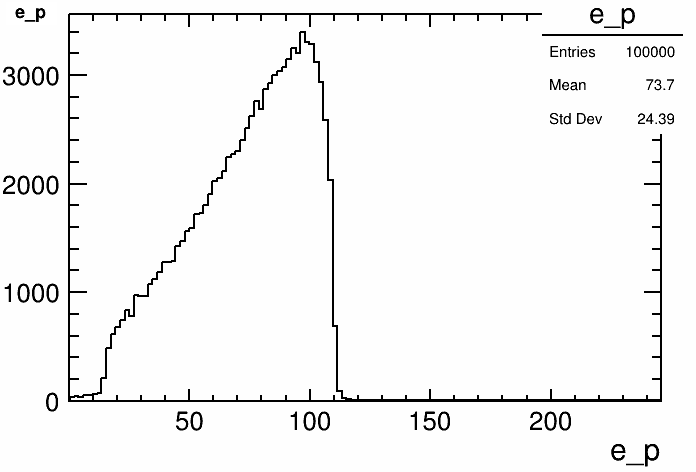

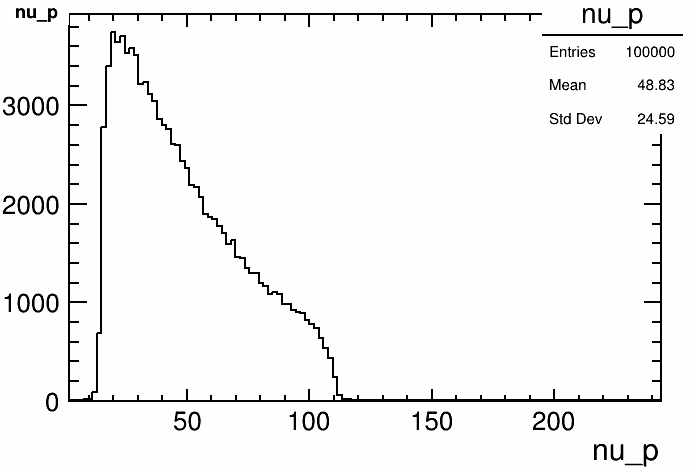

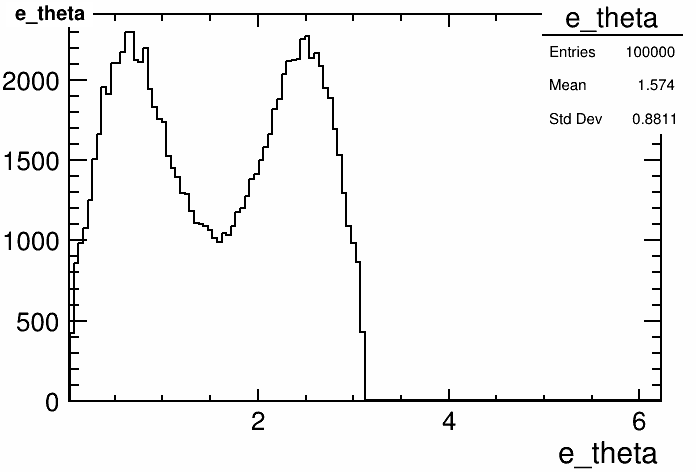

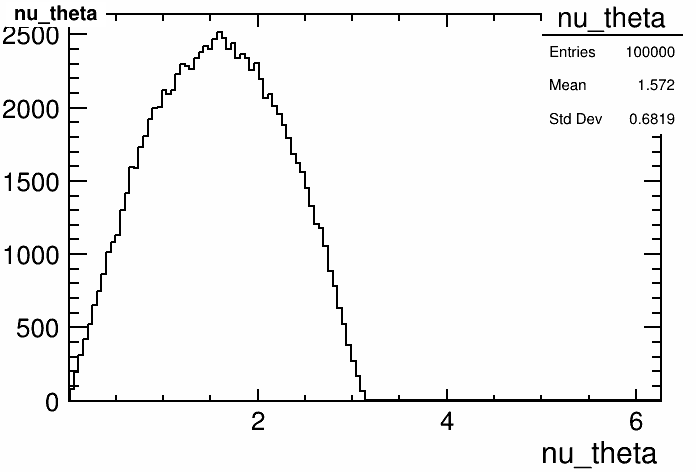

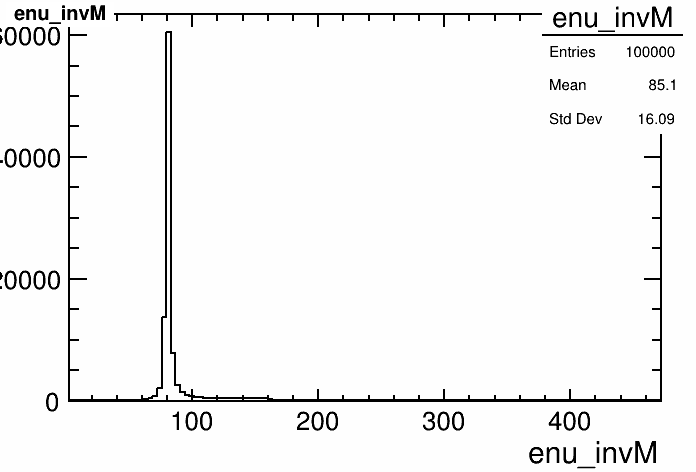

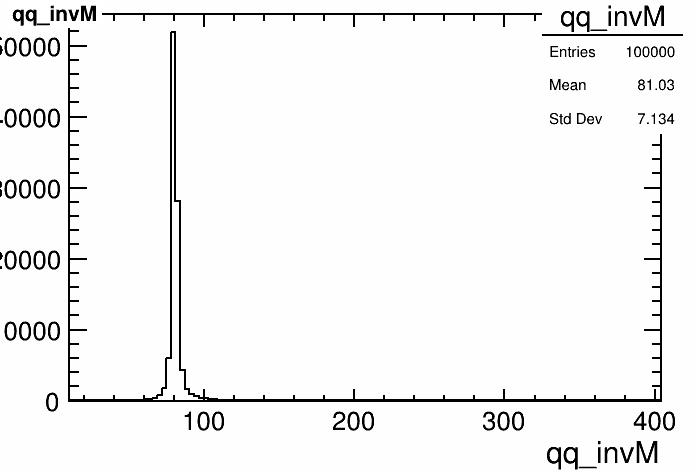

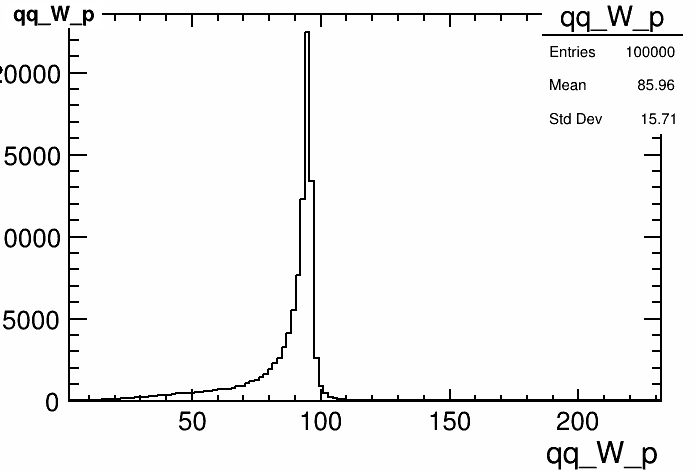

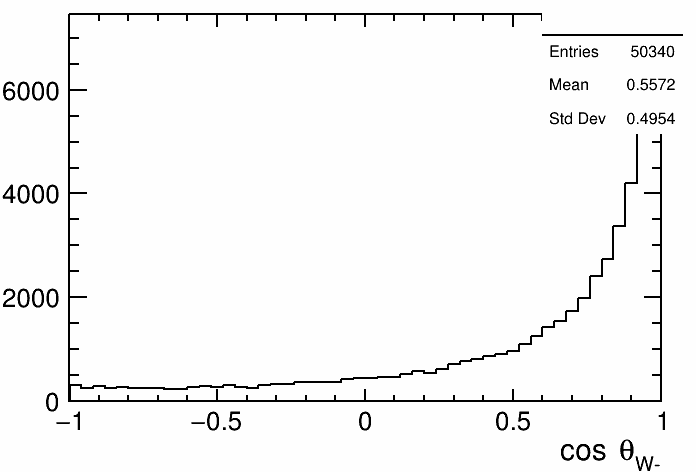

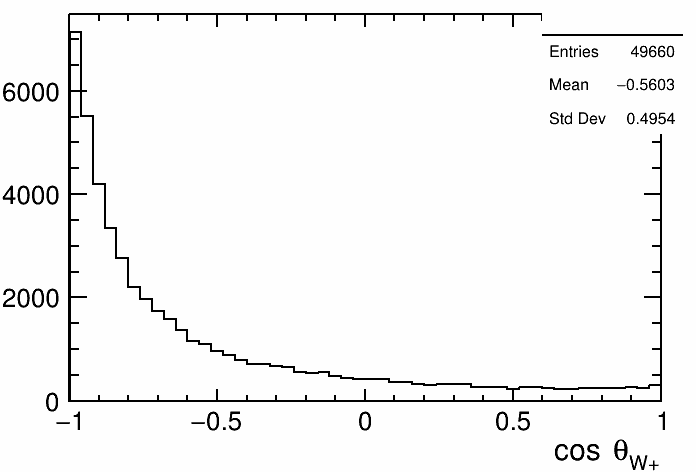

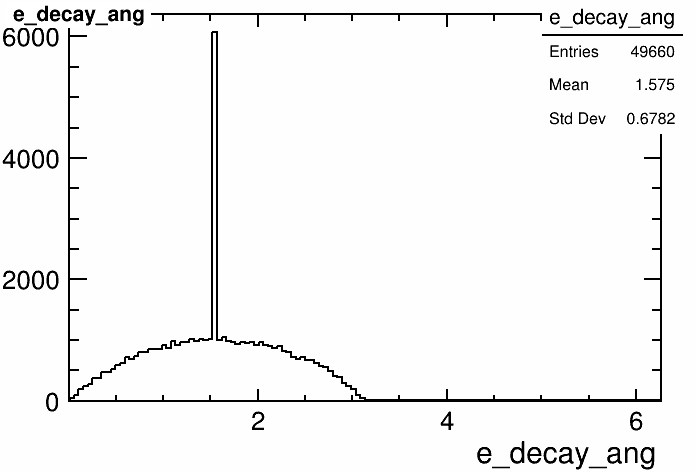

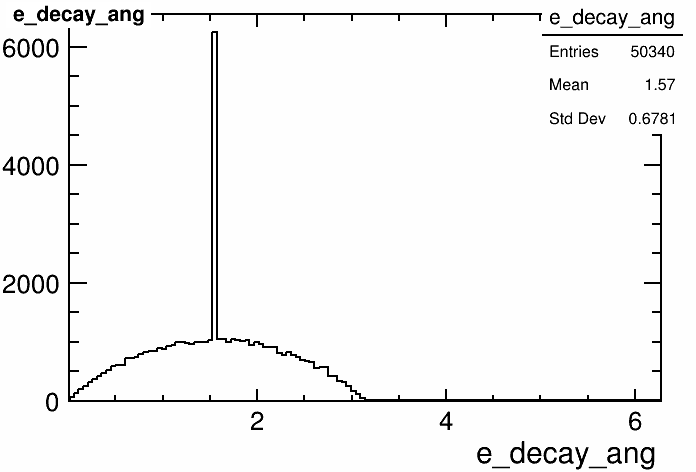

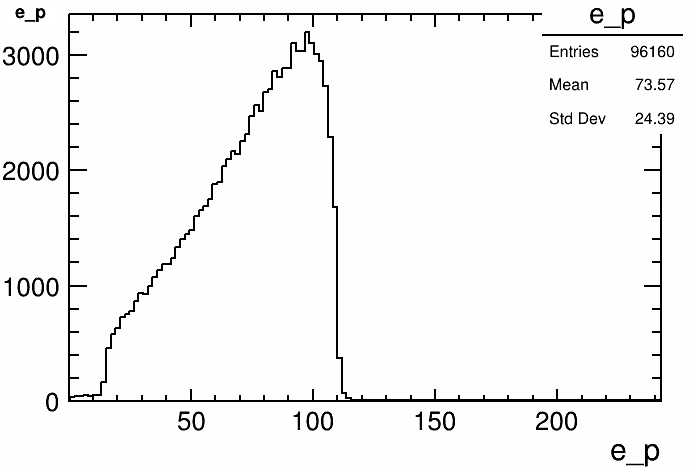

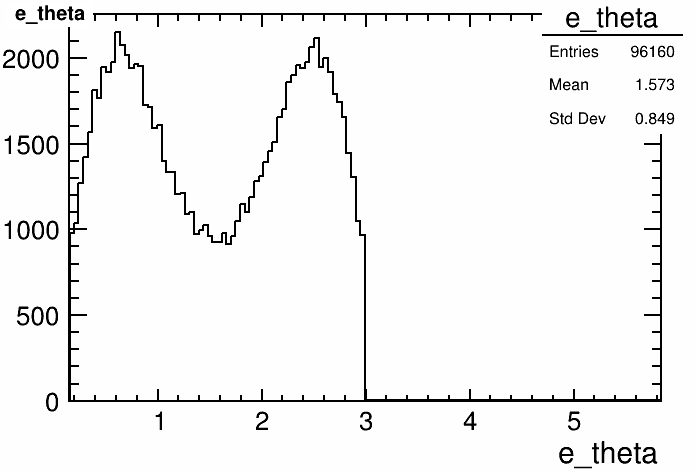

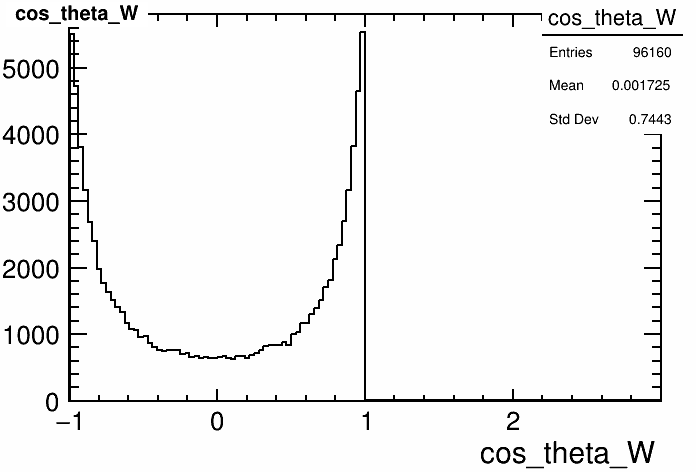

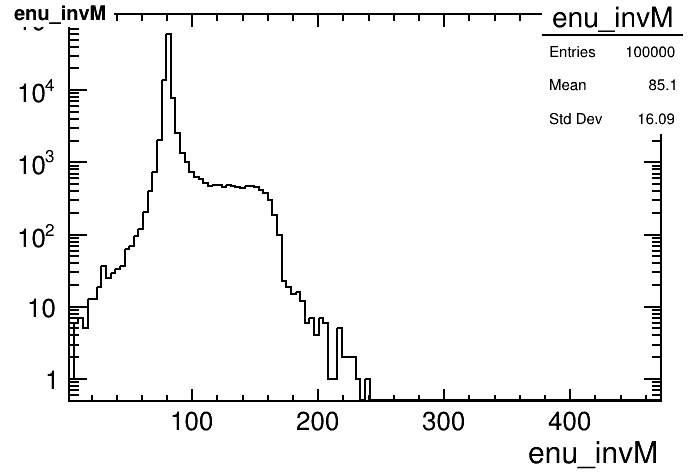

In [13]:
c = {}
for v in h:
    c[v] = ROOT.TCanvas()
    h[v].Draw()
    if (v.endswith("_log")):
        c[v].SetLogy()
    c[v].Draw()
    c[v].SaveAs(f"plots/{v}.png")
    

